This notebook compares a DRP model trained with patient data, augmented with Gaussian noise.

In [ ]:
import pandas as pd
import numpy as np
import pickle
import torch
import torch.nn as nn
import math

In [2]:
from torch.utils.data import TensorDataset, DataLoader
import yaml
import pprint
import os
import wandb
import sys
import random
from scipy.stats import mode, pearsonr
import pickle
import itertools
import sys
sys.path.append("../")


from src.gaussian_multinomial_diffusion import GaussianMultinomialDiffusion
from src.modules import MLPDiffusion
from src.vae_model import vae
from src.loss_functions import get_kld_loss, coral
from model_definition import *

In [3]:
import matplotlib.pyplot as plt

In [4]:
fold = 2

In [ ]:
# global variables

CONFIG_PATH = f"../experiment_settings_yaml/ablation/model_config_2A_annotated_mutations_v7_fold{fold}_noattn_notransformer.yaml" # model config path
pretty_print = pprint.PrettyPrinter()
print(f"Loading config from {CONFIG_PATH}")
config = yaml.safe_load(open(CONFIG_PATH))
model_config = config["model_hyperparams"]
folder_config = config["folder_config"]
wandb_config = config["wandb_config"]
wandb_config["project_name"] = wandb_config["project_name"] + f"-{model_config['experiment_id']}-{model_config['experiment_settings']}-fold{model_config['sample_id']}" # updates wandb project name for ease of monitoring and logging.
device = torch.device(f"cuda:{model_config['device']}" if torch.cuda.is_available() else "cpu")
genes_324 = list(pd.read_csv(f"{folder_config['data_folder']}/raw/metadata/gene2ind.txt", header=None)[0])
drug_fp = pd.read_csv(f"{folder_config['data_folder']}/raw/metadata/drug_morgan_fingerprints.csv", index_col=0)
suffixes = ["_piu_max", "_piu_sum", "_piu_mean", "_piu_count",
            "_lu_max", "_lu_sum", "_lu_mean", "_lu_count",
            "_ncu_max", "_ncu_sum", "_ncu_mean", '_ncu_count',
            "_pathogenic_max", "_pathogenic_sum", "_pathogenic_mean", "_pathogenic_count",
            "_vus_max", "_vus_sum", "_vus_mean", "_vus_count",
            "_benign_max", "_benign_sum", "_benign_mean", "_benign_count"
           ]
genes_7776 = []
for s in suffixes:
    for g in list(pd.read_csv(f"{folder_config['data_folder']}/raw/metadata/gene2ind.txt", header=None)[0]):
        genes_7776.append(f"{g}{s}")

# setting up wandb
os.environ["WANDB_CACHE_DIR"] = wandb_config["wandb_cache_dir"]
os.environ["WANDB_DIR"] = wandb_config["wandb_cache_dir"]
wandb.login(key=wandb_config["api_key"])

# seeding
torch.manual_seed(model_config["seed"])
random.seed(model_config["seed"])
np.random.seed(model_config["seed"])
# reproducibility in data loading - https://pytorch.org/docs/stable/notes/randomness.html
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(model_config["seed"])



In [6]:
def load_datasets(sample_id):
    """
    Takes sample_id as input, loads source and target train, validation and test splits (predefined files from Processing folder).
    """
    data_dir = folder_config["data_folder"] + "input_types/"
    # navigate based on input type
    if model_config["input_data_type"] == "binary_mutations":
        data_dir = data_dir + "raw_mutations/"
        features2select = genes_324  # inclusive of Morgan drug fingerprints of 2048 dim
    elif model_config["input_data_type"] == "annotated_mutations":
        data_dir = data_dir + "annotated_mutations/"
        features2select = genes_7776  # inclusive of Morgan drug fingerprints of 2048 dim
    elif model_config["input_data_type"] == "transformer_inputs": # processed by PREDICT-AI transformer embedder
        data_dir = data_dir + "transformer_inputs_transformed_797/"
        features2select = [f"transformer_embedded_{i}" for i in range(797)] # after transformer embedding
    else:
        print("Unsupported input type!")
        return
    
    # navigate based on experiment id
    if model_config["experiment_id"] == "1A":
        data_dir = data_dir + "Experiment1/SettingA/"
    elif model_config["experiment_id"] == "1B":
        data_dir = data_dir + "Experiment1/SettingB/"
    elif model_config["experiment_id"] == "2A":
        data_dir = data_dir + "Experiment2/SettingA/"
    elif model_config["experiment_id"] == "2B":
        data_dir = data_dir + "Experiment2/SettingB/"
    else:
        print("Unsupported experiment ID!")
        return
    
    # load the fold based on sample_id - Note: cell lines have only 1 fold (fold 0)
    with open(f"{data_dir}/cell_lines_fold0_processed.pkl", "rb") as f:
        source_data = pickle.load(f)

    with open(f"{data_dir}/patients_fold{sample_id}_processed.pkl", "rb") as f:
        target_data = pickle.load(f)

    # load pretrained TCGA VAE and diffusion models
    # pass data points through patient DDPM and get the input to VAE decoder for DRP
    # cl_diff_model, cl_vae, tcga_diff_model, patient_vae = load_pretrained_models()
    
    # select data based on experiment settings 
    # Can be CISPLATIN, PACLITAXEL, FLUOROURACIL, SORAFENIB for 1A, CISPLATIN, TCGA-CESC; CISPLATIN, TCGA-HNSC; PACLITAXEL, TCGA-BRCA; FLUOROURACIL, TCGA-STAD for 1B
    # ALL for 2A, TCGA-BRCA, TCGA-CESC, TCGA-HNSC, TCGA-STAD for 2B
    if model_config["experiment_id"] in ["1A", "2B"]:
        setting = model_config["experiment_settings"]
        train_source_data, val_source_data, test_source_data = source_data["train"][setting], source_data["val"][setting], source_data["test"][setting]
        train_target_data, val_target_data, test_target_data = target_data["train"][setting], target_data["val"][setting], target_data["test"][setting]
    elif model_config["experiment_id"] == "1B":
        setting = (model_config["experiment_settings"].split(", ")[0], model_config["experiment_settings"].split(", ")[1], "TCGA")
        train_source_data, val_source_data, test_source_data = source_data["train"][setting], source_data["val"][setting], source_data["test"][setting]
        train_target_data, val_target_data, test_target_data = target_data["train"][setting], target_data["val"][setting], target_data["test"][setting]
    elif model_config["experiment_id"] == "2A":
        train_source_data, val_source_data, test_source_data = source_data["train"], source_data["val"], source_data["test"]
        train_target_data, val_target_data, test_target_data = target_data["train"], target_data["val"], target_data["test"]
    else:
        print("Unsupported experiment settings and ID")
        return
    
    # merge dataframes with drug Morgan fingprint dataframes
    train_source_data_merged = train_source_data.merge(drug_fp, left_on="drug_name", right_on=drug_fp.index)
    val_source_data_merged = val_source_data.merge(drug_fp, left_on="drug_name", right_on=drug_fp.index)
    test_source_data_merged = test_source_data.merge(drug_fp, left_on="drug_name", right_on=drug_fp.index)

    train_target_data_merged = train_target_data.merge(drug_fp, left_on="drug_name", right_on=drug_fp.index)
    val_target_data_merged = val_target_data.merge(drug_fp, left_on="drug_name", right_on=drug_fp.index)
    test_target_data_merged = test_target_data.merge(drug_fp, left_on="drug_name", right_on=drug_fp.index)

    assert train_source_data_merged.shape[0] == train_source_data.shape[0], "Train source data loss after merge!"
    assert val_source_data_merged.shape[0] == val_source_data.shape[0], "Val source data loss after merge!"
    assert test_source_data_merged.shape[0] == test_source_data.shape[0], "Test source data loss after merge!"
    assert train_target_data_merged.shape[0] == train_target_data.shape[0], "Train target data loss after merge!"
    assert val_target_data_merged.shape[0] == val_target_data.shape[0], "Val target data loss after merge!"
    assert test_target_data_merged.shape[0] == test_target_data.shape[0], "Test target data loss after merge!"

    # separate out into input, drug and labels
    train_source_inputs, val_source_inputs, test_source_inputs = train_source_data_merged[features2select], val_source_data_merged[features2select], test_source_data_merged[features2select]
    # # pass cl samples through cl diff model and vae
    # train_source_inputs_vae = pd.DataFrame(vae_decoder_input(train_source_inputs, cl_vae, cl_diff_model), columns=[f"vae_feat{i}" for i in range(model_config["cl_vae_k_list"][-1]//2)], index=train_source_data_merged.index)
    # val_source_inputs_vae = pd.DataFrame(vae_decoder_input(val_source_inputs, cl_vae, cl_diff_model), columns=[f"vae_feat{i}" for i in range(model_config["cl_vae_k_list"][-1]//2)], index=val_source_data_merged.index)
    # test_source_inputs_vae = pd.DataFrame(vae_decoder_input(test_source_inputs, cl_vae, cl_diff_model), columns=[f"vae_feat{i}" for i in range(model_config["cl_vae_k_list"][-1]//2)], index=test_source_data_merged.index)
    train_source_drugs, val_source_drugs, test_source_drugs = train_source_data_merged[[str(i) for i in range(0, 2048)]].values, val_source_data_merged[[str(i) for i in range(0, 2048)]].values, test_source_data_merged[[str(i) for i in range(0, 2048)]].values
    train_source_labels, val_source_labels, test_source_labels = train_source_data_merged["auc"].values, val_source_data_merged["auc"].values, test_source_data_merged["auc"].values

    train_target_inputs, val_target_inputs, test_target_inputs = train_target_data_merged[features2select], val_target_data_merged[features2select], test_target_data_merged[features2select]
    # pass patient samples through tcga diff model and vae
    # train_target_inputs_vae = pd.DataFrame(vae_decoder_input(train_target_inputs, patient_vae, tcga_diff_model), columns=[f"vae_feat{i}" for i in range(model_config["patient_vae_k_list"][-1]//2)], index=train_target_data_merged.sample_id)
    # val_target_inputs_vae = pd.DataFrame(vae_decoder_input(val_target_inputs, patient_vae, tcga_diff_model), columns=[f"vae_feat{i}" for i in range(model_config["patient_vae_k_list"][-1]//2)], index=val_target_data_merged.sample_id)
    # test_target_inputs_vae = pd.DataFrame(vae_decoder_input(test_target_inputs, patient_vae, tcga_diff_model), columns=[f"vae_feat{i}" for i in range(model_config["patient_vae_k_list"][-1]//2)], index=test_target_data_merged.sample_id)

    train_target_drugs, val_target_drugs, test_target_drugs = train_target_data_merged[[str(i) for i in range(0, 2048)]].values, val_target_data_merged[[str(i) for i in range(0, 2048)]].values, test_target_data_merged[[str(i) for i in range(0, 2048)]].values
    train_target_labels, val_target_labels, test_target_labels = train_target_data_merged["recist"].values, val_target_data_merged["recist"].values, test_target_data_merged["recist"].values

    # return train_source_inputs_vae, train_source_drugs, train_source_labels, val_source_inputs_vae, val_source_drugs, val_source_labels, test_source_inputs_vae, test_source_drugs, test_source_labels, train_target_inputs_vae, train_target_drugs, train_target_labels, val_target_inputs_vae, val_target_drugs, val_target_labels, test_target_inputs_vae, test_target_drugs, test_target_labels, train_target_data_merged, val_target_data_merged, test_target_data_merged, train_source_data_merged, val_source_data_merged, test_source_data_merged
    return train_source_inputs, train_source_drugs, train_source_labels, val_source_inputs, val_source_drugs, val_source_labels, test_source_inputs, test_source_drugs, test_source_labels, train_target_inputs, train_target_drugs, train_target_labels, val_target_inputs, val_target_drugs, val_target_labels, test_target_inputs, test_target_drugs, test_target_labels, train_target_data_merged, val_target_data_merged, test_target_data_merged, train_source_data_merged, val_source_data_merged, test_source_data_merged

    # pass # needs to return (train_source_data, train_source_labels, val_source_data, val_source_labels, test_source_data, test_source_labels), (train_target_data, train_target_labels, val_target_data, val_target_labels, test_target_data, test_target_labels)
    #  Dummy data
    # train_source_data, val_source_data, test_source_data = np.random.rand(32, 2048 + 4), np.random.rand(10, 2048 + 4), np.random.rand(5, 2048 + 4)
    # train_source_labels, val_source_labels, test_source_labels = np.random.randint(2, size=32), np.random.randint(2, size=10), np.random.randint(2, size=5)
    # train_target_data, val_target_data, test_target_data = np.random.rand(32, 2048 + 4), np.random.rand(10, 2048 + 4), np.random.rand(3, 2048 + 4)
    # train_target_labels, val_target_labels, test_target_labels = np.random.randint(2, size=32), np.random.randint(2, size=10), np.random.randint(2, size=3)
    # return train_source_data, train_source_labels, val_source_data, val_source_labels, test_source_data, test_source_labels, train_target_data, train_target_labels, val_target_data, val_target_labels, test_target_data, test_target_labels


In [7]:
train_source_inputs_vae, train_source_drugs, train_source_labels, val_source_inputs_vae, val_source_drugs, val_source_labels, test_source_inputs_vae, test_source_drugs, test_source_labels, train_target_inputs_vae, train_target_drugs, train_target_labels, val_target_inputs_vae, val_target_drugs, val_target_labels, test_target_inputs_vae, test_target_drugs, test_target_labels, train_target_data_merged, val_target_data_merged, test_target_data_merged, train_source_data_merged, val_source_data_merged, test_source_data_merged = load_datasets(sample_id=fold)

In [8]:
train_source_inputs_vae

,ABL1_piu_max,ACVR1B_piu_max,AKT1_piu_max,AKT2_piu_max,AKT3_piu_max,ALK_piu_max,ALOX12B_piu_max,APC_piu_max,AR_piu_max,ARAF_piu_max,...,U2AF1_benign_count,VEGFA_benign_count,VHL_benign_count,WHSC1_benign_count,WHSC1L1_benign_count,WT1_benign_count,XPO1_benign_count,XRCC2_benign_count,ZNF217_benign_count,ZNF703_benign_count
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235294,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.411765,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


No augmentation run

In [9]:
# create datasets
# Cell Lines
# source_dataset_train = TensorDataset(torch.FloatTensor(train_source_data_merged.filter(regex="transformer_embedded_*").values), torch.FloatTensor(train_source_data_merged[[str(i) for i in range(0, 2048)]].values), torch.FloatTensor(train_source_data_merged["auc"].values))
# source_dataset_val = TensorDataset(torch.FloatTensor(val_source_data_merged.filter(regex="transformer_embedded_*").values), torch.FloatTensor(val_source_data_merged[[str(i) for i in range(0, 2048)]].values), torch.FloatTensor(val_source_data_merged["auc"].values))
# source_dataset_test = TensorDataset(torch.FloatTensor(test_source_data_merged.filter(regex="transformer_embedded_*").values), torch.FloatTensor(test_source_data_merged[[str(i) for i in range(0, 2048)]].values), torch.FloatTensor(test_source_data_merged["auc"].values))

# Patients
target_dataset_train = TensorDataset(torch.FloatTensor(train_target_data_merged[genes_7776].values), torch.FloatTensor(train_target_data_merged[[str(i) for i in range(0, 2048)]].values), torch.FloatTensor(train_target_data_merged["recist"].values))
target_dataset_val = TensorDataset(torch.FloatTensor(val_target_data_merged[genes_7776].values), torch.FloatTensor(val_target_data_merged[[str(i) for i in range(0, 2048)]].values), torch.FloatTensor(val_target_data_merged["recist"].values))
target_dataset_test = TensorDataset(torch.FloatTensor(test_target_data_merged[genes_7776].values), torch.FloatTensor(test_target_data_merged[[str(i) for i in range(0, 2048)]].values), torch.FloatTensor(test_target_data_merged["recist"].values))


In [10]:
# data loaders
# source_dataloader_train = DataLoader(source_dataset_train, batch_size = 512, shuffle = True, worker_init_fn = seed_worker, generator = g)
target_dataloader_train = DataLoader(target_dataset_train, batch_size = 512, shuffle = True, worker_init_fn = seed_worker, generator = g)

# source_dataloader_val = DataLoader(source_dataset_val, batch_size = 512, shuffle = False, worker_init_fn = seed_worker, generator = g)
target_dataloader_val = DataLoader(target_dataset_val, batch_size = 512, shuffle = False, worker_init_fn = seed_worker, generator = g)

# source_dataloader_test = DataLoader(source_dataset_test, batch_size = 512, shuffle = False, worker_init_fn = seed_worker, generator = g)
target_dataloader_test = DataLoader(target_dataset_test, batch_size = 512, shuffle = False, worker_init_fn = seed_worker, generator = g)



In [11]:
class DRP(nn.Module):
    def __init__(self):
        super().__init__()
        self.patient_embedder = nn.Sequential(nn.Linear(7776, 128), nn.ReLU(), nn.Linear(128, 64))
        self.drug_embedder = nn.Sequential(nn.Linear(2048, 256), nn.ReLU(), nn.Linear(256, 64))
        self.recist_predictor = nn.Sequential(nn.Linear(64 * 2, 16), nn.ReLU(), nn.Linear(16, 1))

    def forward(self, patient_inp, patient_drug):
        # patient_inp is 797 dim, drugs are 2048 dim
        patient_emb = self.patient_embedder(patient_inp)
        patient_drug_emb = self.drug_embedder(patient_drug)
        patient_cat = torch.cat((patient_emb, patient_drug_emb), axis = 1)

        # recist prediction
        recist_pred = self.recist_predictor(patient_cat)

        return recist_pred
        

In [12]:
def inference_drp_model(model, patient_val_dataloader):
    model.eval()
    y_preds = []
    y_trues = []
    for idx, batch in enumerate(patient_val_dataloader):
        with torch.no_grad():
            patient_inp = batch[0].to(device)
            patient_drug = batch[1].to(device)
            label = batch[2].to(device)
            y_preds.append(nn.Sigmoid()(model(patient_inp, patient_drug)).view(-1, 1))
            y_trues.append(label.view(-1, 1))
    return torch.cat(y_preds), torch.cat(y_trues)

In [13]:
def train_drp_model(model, train_dataloader, patient_val_dataloader, num_epochs=100, lr=1e-3):
    """
    To train vanilla baseline model
    """
    criterion = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(model.parameters(), lr = lr)
    # training 
    val_corrs = []
    train_loss_terms = []
    val_loss_terms = []
    count = 0
    for i in range(num_epochs):
        model.train()
        train_losses = []
        # if i > 10 and i % 10 == 0:
        #     lr = lr/10
        #     optim = torch.optim.Adam(model.parameters(), lr = lr)
        for idx, batch in enumerate(train_dataloader):
            optim.zero_grad()
            patient_inp = batch[0].to(device)
            patient_drug = batch[1].to(device)
            label = batch[2].to(device)
            y_pred = model(patient_inp, patient_drug).view(-1, 1)
            loss = criterion(y_pred, label.view(-1, 1).to(device, dtype=torch.float32))
            loss.backward()
            optim.step()
            train_losses.append(loss.item())

        y_test_pred, test_y = inference_drp_model(model, patient_val_dataloader)
        val_loss = criterion(y_test_pred.view(-1), test_y.float().view(-1))
        patient_corr = pearsonr(test_y.detach().cpu().numpy().reshape(-1), y_test_pred.detach().cpu().numpy().reshape(-1)).statistic + 1 # range in [0, 2]
        

        val_corrs.append(patient_corr)
        val_loss_terms.append(val_loss.detach().cpu().numpy())
        train_loss_terms.append(np.mean(train_losses))
        print(f"Epoch {i}: Training loss: {np.mean(train_losses)} |  Validation correlation: {patient_corr}")

        # wandb.log({
        #     f"{model.model_name}_train_loss": loss.detach().item(),
        #     f"validation_score": patient_corr
        # })
        # convergence based on val score
        # if len(val_corrs) == 1: # first epoch
        #     best_val_score = patient_corr

        # # save model
        # if model_config["model_save_criteria"] in ["val_AUROC", "val_AUPRC", "val_corr"]: # maximise values
        #     if patient_corr >= best_val_score:
        #         best_val_score = patient_corr
        #         # save model
        #         print("Best model")
        #         torch.save(model.state_dict(), f"{folder_config['model_checkpoint_folder']}/{model.model_name}_{model_config['model_save_criteria']}_{model_config['experiment_id']}_{model_config['experiment_settings']}_fold{model_config['sample_id']}.pth")
        #         count = 0 # reset count
        #     else:
        #         count += 1 # declining performance on validation data
        # else:
        #     print("Unsupported metric for optimising")
        #     return
        
        # if count >= 3:
        #     print("Converged")
        #     break

    return val_corrs, train_loss_terms, val_loss_terms
        # # convergence checking based on validation correlation
        # if len(val_corrs) > 2:
        #     if val_corrs[-1] < val_corrs[-2]: # maximise correlation
        #         count += 1
        #     else:
        #         print("Best model")
        #         torch.save(model.state_dict(), f"{folder_config['model_checkpoint_folder']}/{model.model_name}_{model_config['model_save_criteria']}_{model_config['experiment_id']}_{model_config['experiment_settings']}_fold{model_config['sample_id']}.pth")
        #         count = 0
        # if len(val_corrs) == 1:
        #     torch.save(model.state_dict(), f"{folder_config['model_checkpoint_folder']}/{model.model_name}_{model_config['model_save_criteria']}_{model_config['experiment_id']}_{model_config['experiment_settings']}_fold{model_config['sample_id']}.pth")
        # if count > 3:
        #     print("Converged")
        #     break

In [14]:
# initialise the DRP NN 
nn_drp = DRP().to(device)
nn_drp.model_name = "DRP_model"

# Train DRP model with only patient data
val_corrs, train_losses, val_loss_terms = train_drp_model(nn_drp, target_dataloader_train, target_dataloader_val, num_epochs=400, lr=1e-3)

Epoch 0: Training loss: 0.6824487447738647 |  Validation correlation: 1.495489964099985
Epoch 1: Training loss: 0.6709687113761902 |  Validation correlation: 1.4897227287981174
Epoch 2: Training loss: 0.6584837436676025 |  Validation correlation: 1.4819615825109433
Epoch 3: Training loss: 0.6436145901679993 |  Validation correlation: 1.475920600197806
Epoch 4: Training loss: 0.625801682472229 |  Validation correlation: 1.473038812932105
Epoch 5: Training loss: 0.6054394245147705 |  Validation correlation: 1.4754928002982988
Epoch 6: Training loss: 0.5836511254310608 |  Validation correlation: 1.4828330714121463
Epoch 7: Training loss: 0.5617120265960693 |  Validation correlation: 1.4920052593929505
Epoch 8: Training loss: 0.5411859750747681 |  Validation correlation: 1.503123950855258
Epoch 9: Training loss: 0.5231893062591553 |  Validation correlation: 1.5147592137668071
Epoch 10: Training loss: 0.5085108876228333 |  Validation correlation: 1.5239728742359406
Epoch 11: Training loss: 

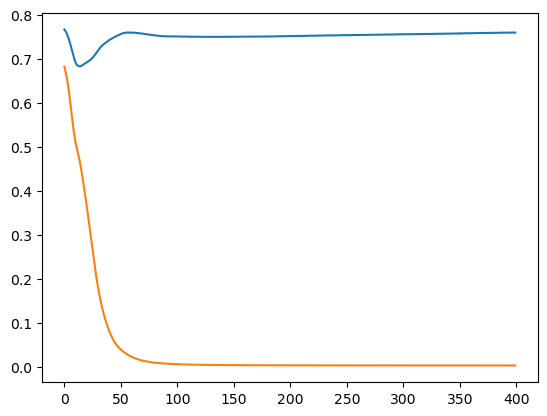

In [15]:
fig, ax = plt.subplots(1, 1)
# ax.plot(val_corrs)
ax.plot(val_loss_terms)
ax.plot(train_losses)

In [16]:
from sklearn.metrics import roc_auc_score, average_precision_score
y_test_pred, test_y = inference_drp_model(nn_drp, target_dataloader_test)
res_df = pd.DataFrame()
res_df["y_pred"] = y_test_pred.cpu().detach().numpy().reshape(-1)
res_df["y_true"] = test_y.cpu().detach().numpy().reshape(-1)


In [17]:
roc_auc_score(res_df["y_true"], res_df["y_pred"])

0.6246811224489797

In [18]:
average_precision_score(res_df["y_true"], res_df["y_pred"])

0.5870127438832993

With augmented data

In [19]:
train_target_data_merged

,sample_id,drug_name,recist,mappedProject,dataset_name,ABL1_piu_max,ACVR1B_piu_max,AKT1_piu_max,AKT2_piu_max,AKT3_piu_max,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,P-0021780-T01-IM6,SORAFENIB,0,TCGA-LIHC,CBIO_hcc_mskimpact_2018,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,TCGA-A5-A1OH,CARBOPLATIN,1,TCGA-UCEC,TCGA,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-DX-A7EQ,DOXORUBICIN,0,TCGA-SARC,TCGA,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-FB-A5VM,GEMCITABINE,0,TCGA-PAAD,TCGA,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,s_DS_bkm_035_T,BUPARLISIB,0,TCGA-BRCA,CBIO_brca_mskcc_2019,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,TCGA-GN-A8LK,CARBOPLATIN,0,TCGA-SKCM,TCGA,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
483,TCGA-EX-A3L1,CISPLATIN,1,TCGA-CESC,TCGA,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
484,TCGA-3A-A9IC,FLUOROURACIL,0,TCGA-PAAD,TCGA,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
485,P-0020359-T01-IM6,SORAFENIB,0,TCGA-LIHC,CBIO_hcc_mskimpact_2018,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [20]:
gaussian_target_df = pd.DataFrame(np.random.normal(0, 1,train_target_data_merged[genes_7776].shape) + train_target_data_merged[genes_7776].values, columns = genes_7776)
gaussian_target_df = pd.concat([gaussian_target_df, train_target_data_merged[[str(i) for i in range(0, 2048)]], train_target_data_merged[["recist"]]], axis=1)
gaussian_target_df

,ABL1_piu_max,ACVR1B_piu_max,AKT1_piu_max,AKT2_piu_max,AKT3_piu_max,ALK_piu_max,ALOX12B_piu_max,APC_piu_max,AR_piu_max,ARAF_piu_max,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,recist
0,1.764052,0.400157,0.978738,2.240893,1.867558,-0.683160,0.950088,-0.151357,-0.103219,0.410599,...,0,0,0,0,1,0,0,0,0,0
1,0.728263,0.115932,-1.415487,0.316568,0.878322,-1.156103,0.557265,1.500416,-0.851163,-0.593949,...,0,0,0,0,0,0,0,0,0,1
2,-0.776001,-2.506804,0.475956,-0.901019,0.014563,0.898762,0.335319,0.960668,-0.287468,-2.993960,...,0,0,0,0,0,0,0,0,0,0
3,0.359623,0.055660,2.660468,-0.355970,-0.814057,1.260989,0.700954,1.602348,-1.686620,-0.353956,...,0,0,0,1,0,0,0,0,0,0
4,-0.380628,0.886814,1.433796,0.301324,0.358733,-1.238670,-0.891162,0.085927,1.194348,-0.636768,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,-0.954310,-2.098738,0.371958,-0.369498,1.573449,0.955838,0.600154,1.226870,-1.039534,-0.470707,...,0,0,0,0,0,0,0,0,0,0
483,-0.026811,-0.398186,-0.806977,-0.161173,-0.428347,0.239373,-0.398317,-0.369510,1.572645,-1.733450,...,0,0,0,0,0,0,0,0,0,1
484,-0.546586,0.035598,-1.396233,1.256363,0.454406,0.234967,0.575797,-0.005039,-1.613303,0.216325,...,0,0,0,0,0,0,0,0,0,0
485,-0.137275,0.260609,0.767893,1.310767,-0.135461,-0.444913,-1.461511,-0.328866,2.099159,-1.221155,...,0,0,0,0,1,0,0,0,0,0


In [21]:
updated_train_target_df = pd.concat([gaussian_target_df, train_target_data_merged[gaussian_target_df.columns]])
updated_train_target_df

,ABL1_piu_max,ACVR1B_piu_max,AKT1_piu_max,AKT2_piu_max,AKT3_piu_max,ALK_piu_max,ALOX12B_piu_max,APC_piu_max,AR_piu_max,ARAF_piu_max,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,recist
0,1.764052,0.400157,0.978738,2.240893,1.867558,-0.683160,0.950088,-0.151357,-0.103219,0.410599,...,0,0,0,0,1,0,0,0,0,0
1,0.728263,0.115932,-1.415487,0.316568,0.878322,-1.156103,0.557265,1.500416,-0.851163,-0.593949,...,0,0,0,0,0,0,0,0,0,1
2,-0.776001,-2.506804,0.475956,-0.901019,0.014563,0.898762,0.335319,0.960668,-0.287468,-2.993960,...,0,0,0,0,0,0,0,0,0,0
3,0.359623,0.055660,2.660468,-0.355970,-0.814057,1.260989,0.700954,1.602348,-1.686620,-0.353956,...,0,0,0,1,0,0,0,0,0,0
4,-0.380628,0.886814,1.433796,0.301324,0.358733,-1.238670,-0.891162,0.085927,1.194348,-0.636768,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.882353,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
485,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,1,0,0,0,0,0


In [22]:
# Patients
target_dataset_train = TensorDataset(torch.FloatTensor(updated_train_target_df[genes_7776].values), torch.FloatTensor(updated_train_target_df[[str(i) for i in range(0, 2048)]].values), torch.FloatTensor(updated_train_target_df["recist"].values))
target_dataset_val = TensorDataset(torch.FloatTensor(val_target_data_merged[genes_7776].values), torch.FloatTensor(val_target_data_merged[[str(i) for i in range(0, 2048)]].values), torch.FloatTensor(val_target_data_merged["recist"].values))
target_dataset_test = TensorDataset(torch.FloatTensor(test_target_data_merged[genes_7776].values), torch.FloatTensor(test_target_data_merged[[str(i) for i in range(0, 2048)]].values), torch.FloatTensor(test_target_data_merged["recist"].values))


In [23]:
# data loaders
target_dataloader_train = DataLoader(target_dataset_train, batch_size = 512, shuffle = True, worker_init_fn = seed_worker, generator = g)

target_dataloader_val = DataLoader(target_dataset_val, batch_size = 512, shuffle = False, worker_init_fn = seed_worker, generator = g)

target_dataloader_test = DataLoader(target_dataset_test, batch_size = 512, shuffle = False, worker_init_fn = seed_worker, generator = g)



In [24]:
# initialise the DRP NN 
nn_drp1 = DRP().to(device)
nn_drp1.model_name = "DRP_model"

# Train DRP model with only patient data
val_corrs1, train_losses1, val_loss_terms1 = train_drp_model(nn_drp1, target_dataloader_train, target_dataloader_val, num_epochs=400, lr=1e-3)

Epoch 0: Training loss: 0.6765739023685455 |  Validation correlation: 1.4843798238162096
Epoch 1: Training loss: 0.6236314475536346 |  Validation correlation: 1.4747691095451336
Epoch 2: Training loss: 0.5595917403697968 |  Validation correlation: 1.4783569045752825
Epoch 3: Training loss: 0.4789575934410095 |  Validation correlation: 1.4809652176868249
Epoch 4: Training loss: 0.3970206379890442 |  Validation correlation: 1.4837459071702943
Epoch 5: Training loss: 0.32648399472236633 |  Validation correlation: 1.4863578475626702
Epoch 6: Training loss: 0.27632148563861847 |  Validation correlation: 1.4887795046020311
Epoch 7: Training loss: 0.24374950677156448 |  Validation correlation: 1.4859338534765483
Epoch 8: Training loss: 0.22223375737667084 |  Validation correlation: 1.4762233428713225
Epoch 9: Training loss: 0.21163959056138992 |  Validation correlation: 1.4649532361287303
Epoch 10: Training loss: 0.1998940333724022 |  Validation correlation: 1.450267115005254
Epoch 11: Traini

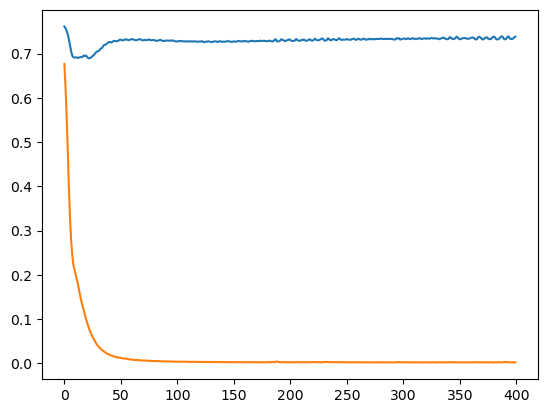

In [25]:
fig, ax = plt.subplots(1, 1)
# ax.plot(val_corrs1)
ax.plot(val_loss_terms1)
ax.plot(train_losses1)

In [26]:
y_test_pred, test_y = inference_drp_model(nn_drp1, target_dataloader_test)
res_df = pd.DataFrame()
res_df["y_pred"] = y_test_pred.cpu().detach().numpy().reshape(-1)
res_df["y_true"] = test_y.cpu().detach().numpy().reshape(-1)

In [27]:
roc_auc_score(res_df["y_true"], res_df["y_pred"])

0.6458864795918368

In [28]:
average_precision_score(res_df["y_true"], res_df["y_pred"])

0.6177440027559941

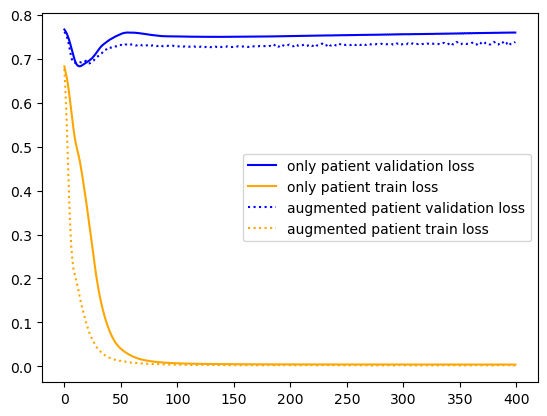

In [29]:
fix, ax = plt.subplots(1, 1)
ax.plot(val_loss_terms, color="blue", label="only patient validation loss")
ax.plot(train_losses, color="orange", label="only patient train loss")
ax.plot(val_loss_terms1, linestyle=":", color="blue", label="augmented patient validation loss")
ax.plot(train_losses1, linestyle=":", color="orange", label="augmented patient train loss")
ax.legend()